In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yahooFinance
import keras

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
stock_name = '^NSEI'

stockInfo = yahooFinance.Ticker(stock_name)

pd.set_option('expand_frame_repr', False)

start = '2007-01-01'
end = '2024-12-01'

data = stockInfo.history(period="max", interval="1d", start=start, end=end)

In [3]:
# Preprocess the data
# Assuming 'Close' is the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [4]:
# Create training and testing datasets
prediction_days = 90  # Number of days to predict
x_train, y_train = [], []

# Using list comprehension to populate x_train and y_train
for i in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert lists to numpy arrays at once
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to be in 3D (samples, time steps, features) for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Now x_train and y_train are ready for model training

In [5]:
# Build the LSTM model

# Define the input shape based on x_train
input_shape = (x_train.shape[1], 1)

model = Sequential()

# First layer with Input(shape)
model.add(keras.Input(shape=input_shape))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback to avoid overfitting
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
# model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 0.0139 - val_loss: 0.0014
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - loss: 5.4440e-04 - val_loss: 4.9019e-04
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 4.8087e-04 - val_loss: 9.7867e-04
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 4.1532e-04 - val_loss: 7.9603e-04
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 4.1535e-04 - val_loss: 6.4027e-04
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.7765e-04 - val_loss: 3.4724e-04
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: 3.6548e-04 - val_loss: 7.2619e-04
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.5342e-04 - val_loss: 3.4726e-04
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.6361e-04 - val_loss: 7.9438e-04
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.3450e-04 - val_loss: 3.6288e-04
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - 

In [6]:
# Define the test period
test_start = dt.datetime(2024, 8, 1)
test_end = dt.datetime(2024, 11, 1)

# Get the test data
test_data = stockInfo.history(period="max", start=test_start, end=test_end)

# Alternatively, load test data from CSV if needed
# test_data = pd.read_csv('nifty_50_nov_2010_oct_2024.csv')

# Extract actual closing prices for the test period
actual_prices = test_data['Close'].values

# Concatenate the historical data and test data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Prepare model inputs for prediction
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)  # Reshape for scaling

model_inputs = pd.DataFrame(model_inputs)

model_inputs = scaler.transform(model_inputs)  # Scale using the same scaler

# Prepare the input data for the LSTM model
x_test = []

# Create input sequences for prediction (sliding window)
for i in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[i - prediction_days:i, 0])

# Convert the list to a numpy array and reshape for LSTM input
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the stock prices
predicted_prices = model.predict(x_test)

# Inverse transform the predicted prices to get the actual scale
predicted_prices = scaler.inverse_transform(predicted_prices)

# Optionally, you can return or display the predicted prices
# print(predicted_prices)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 


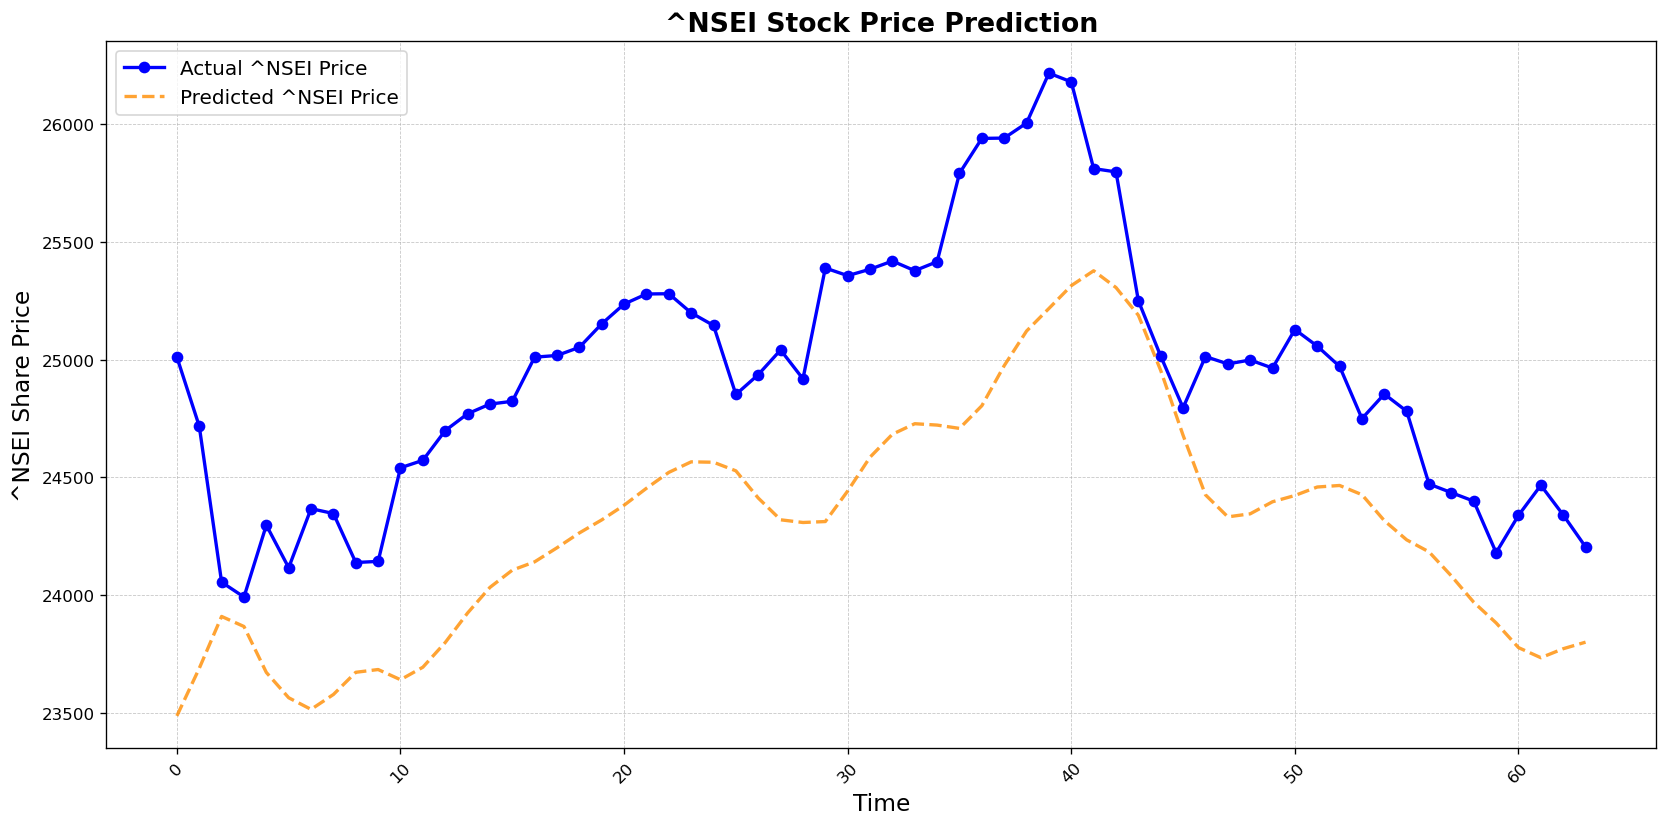

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction for the next day: 5743.5732421875


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure with optimized size and resolution
plt.figure(figsize=(14, 7), dpi=120)

# Plot Actual Prices with distinct style
plt.plot(
    range(len(actual_prices)),  # x-axis: time steps or index
    actual_prices, 
    marker='o', 
    color='blue', 
    linestyle='-', 
    linewidth=2, 
    label=f"Actual {stock_name} Price"
)

# Plot Predicted Prices with a contrasting style
plt.plot(
    range(len(predicted_prices)), 
    predicted_prices, 
    color='darkorange', 
    linestyle='--', 
    linewidth=2, 
    alpha=0.8, 
    label=f"Predicted {stock_name} Price"
)

# Add a title with the stock name and model for context
plt.title(
    f"{stock_name} Stock Price Prediction", 
    fontsize=16, 
    fontweight='bold'
)

# Set labels for the axes with larger, readable font sizes
plt.xlabel("Time", fontsize=14)
plt.ylabel(f"{stock_name} Share Price", fontsize=14)

# Rotate x-axis labels for better readability if dense
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add a grid with a subtle style
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with improved size and placement
plt.legend(fontsize=12, loc='upper left')

# Automatically adjust layout to avoid clipping
plt.tight_layout()

# Save the figure as an image
plt.savefig(f"{stock_name}_stock_price_prediction.png")

# Show the plot
plt.show()

# Preparing the real data for the prediction
real_data = model_inputs[-prediction_days:].reshape(-1, 1)  # Get the last `prediction_days` values
real_data = scaler.transform(real_data)  # Scale the data

# Reshape for LSTM input
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Make the prediction using the trained model
prediction = model.predict(real_data)

# Inverse transform to get actual price scale
prediction = scaler.inverse_transform(prediction)

# Output the prediction
print(f"Prediction for the next day: {prediction[0][0]}")